In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
import difflib


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [82]:
players = pd.read_pickle(os.path.join('Data', 'final_players.pkl')).reset_index(drop = True)
games = pd.read_pickle(os.path.join('Data', 'final_games.pkl')).reset_index(drop = True)

# I saved code people to save time from 1 hr cell below, run this code to see output
# games = pd.read_pickle(os.path.join('Data' , 'final_game_pca.pkl'))

In [83]:
players.columns

Index(['SeasonRank', 'Player', 'Team', 'GP', 'MPG', 'FGM', 'FGA', 'FG%', '3PM',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'TOV', 'PF', 'ORB', 'DRB', 'RPG',
       'APG', 'SPG', 'BPG', 'PPG', 'Year'],
      dtype='object')

## PCA TO GET PLAYER RATINGS (OFFENSIVE AND DEFENSIVE)

Now let's do some PCA to reduce some dimensions for player averages. I will be performing PCA to get ratings on offensive and defensive ratings. Of course since most fo these categories are scaled differently, normalizing to get the most accurate offensive and defensive score is probably pretty important.
     
PCA loses information however, so I will be making ensuring that a reasonable amount of information isn't lost(meaning explained variance is above a threshhold of at least .60 as recommended in this book: [book_link](amazon.com/Multivariate-Data-Analysis-Joseph-Hair/dp/0138132631). However, I probably still want to keep a lot more information that .60%. In this project, I will be using a threshold of .8

In [84]:
offensive_cols = ['FGM', 'FGA','3PM','3PA','FTM', 'FTA','PPG', 'APG','ORB','TOV']

## keeping two components for offense
p1 = Pipeline([('std' ,StandardScaler()), ('pca',PCA(2))])

## PRINTS OUT THE EXPLAINED VARIANCE
proj =p1.fit_transform(players[offensive_cols])
print(p1.named_steps['pca'].explained_variance_ratio_)

#ADDING OFFENSE COMPONENTS TO OG DATA SET
players = pd.concat([players,pd.DataFrame(p1.fit_transform(players[offensive_cols]))], axis = 1)
players = players.rename(columns = {0:'OFFENSIVE_COMP1', 1:'OFFENSIVE_COMP2'})

[0.62537892 0.2472637 ]


As you can see we do get Klay, Durant and Curry as outliers as expected

In [91]:
defensive_cols = ['BPG', 'SPG', 'DRB']

## keeping two components for offense
p2 = Pipeline([('std' ,StandardScaler()), ('pca',PCA(2))])

## PRINTS OUT THE EXPLAINED VARIANCE
proj = p2.fit_transform(players[defensive_cols])
print(p2.named_steps['pca'].explained_variance_ratio_)

#ADDING DEFENSE COMPONENTS TO OG DATA SET
players = pd.concat([players,pd.DataFrame(p2.fit_transform(players[defensive_cols]))], axis = 1)
players = players.rename(columns = {0:'DEFENSIVE_COMP1', 1:'DEFENSIVE_COMP2'})

[0.58214606 0.31214232]


#### Checking PCA Offensive and Defensive Components through Warriors Example

Below is how I check my PCA catches enough info. I will be doing this on the Warriors 2019 nba team. Season Rank gives us intuition on how good the player is, so they should deviate. Although they robbed Draymond >:(

In [98]:
gsw_2019.head()

,SeasonRank,Player,Team,GP,MPG,FGM,FGA,FG%,3PM,3PA,...,RPG,APG,SPG,BPG,PPG,Year,OFFENSIVE_COMP1,OFFENSIVE_COMP2,DEFENSIVE_COMP1,DEFENSIVE_COMP2
973,6,Stephen Curry,GSW,69,33.8,9.2,19.4,0.472,5.1,11.7,...,5.3,5.2,1.3,0.4,27.3,2019,9.598023,-2.333685,0.727999,-1.141284
976,9,Kevin Durant,GSW,78,34.6,9.2,17.7,0.521,1.8,5.0,...,6.4,5.9,0.7,1.1,26.0,2019,4.696268,1.571512,1.611731,0.873796
987,20,Klay Thompson,GSW,78,34.0,8.4,18.0,0.467,3.1,7.7,...,3.8,2.4,1.1,0.6,21.5,2019,5.251319,-1.308240,0.336100,-0.567150
1179,212,Draymond Green,GSW,66,31.3,2.8,6.4,0.445,0.7,2.5,...,7.3,6.9,1.4,1.1,7.4,2019,-0.055631,0.720067,2.408718,-0.645833
1195,228,Quinn Cook,GSW,74,14.3,2.8,5.9,0.465,1.1,2.7,...,2.1,1.6,0.3,0.0,6.9,2019,-1.109963,-1.392783,-1.779233,0.573225


Now lets make sure that the Offensive Components catch enough information by plotting it and checking if stand out players(all stars) actually deviate from the rest of the players. This should be the case because better offensive players should be an outlier from the bench players.

To check this, I will make a scatter plot on the best team in the NBA :) (Totally Not Biased). 

As you can see we do get Klay, Durant and Curry as outliers as expected

Text(0.5, 1.0, 'GSW Offensive PCA PLOT')

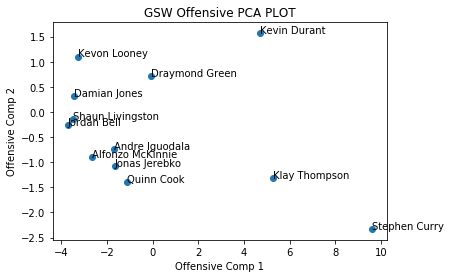

In [75]:
## creating the gsw 2019 subplot
gsw_2019 = players[(players['Team'] == 'GSW') & (players['Year'] == 2019)]

## creating the gsw players corrdinates and names
gsw_players = list(gsw_2019['Player'])
off_comp_1 = list(gsw_2019['OFFENSIVE_COMP1'])
off_comp_2 = list(gsw_2019['OFFENSIVE_COMP2'])

## making the scatterplot
fig, ax = plt.subplots()
ax.scatter(off_comp_1, off_comp_2)

## annottating it
for i, txt in enumerate(gsw_players):
    ax.annotate(txt, (off_comp_1[i], off_comp_2[i]))

## labeling plots
plt.xlabel('Offensive Comp 1')
plt.ylabel('Offensive Comp 2')
plt.title('GSW Offensive PCA PLOT')

Let's do the same thing for defensive stats with the same data.

We observe that Iggy, KD, Klay, Steph, and Draymond appear to be clustered and the other bench players are clustered as well. This is what we expect as the "Hampton 5" is known for their defense and they probably get more defensive stats because they play more.

Text(0.5, 1.0, 'GSW DEFENSIVE PCA PLOT')

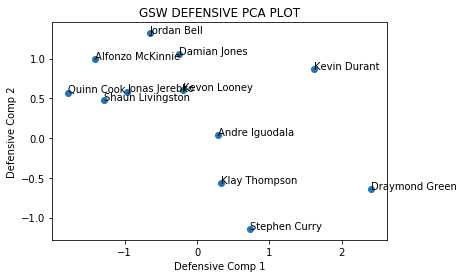

In [94]:
## creating the gsw players corrdinates and names
gsw_players = list(gsw_2019['Player'])
def_comp_1 = list(gsw_2019['DEFENSIVE_COMP1'])
def_comp_2 = list(gsw_2019['DEFENSIVE_COMP2'])

## making the scatterplot
fig, ax = plt.subplots()
ax.scatter(def_comp_1, def_comp_2)

## annottating it
for i, txt in enumerate(gsw_players):
    ax.annotate(txt, (def_comp_1[i], def_comp_2[i]))

## labeling plots
plt.xlabel('Defensive Comp 1')
plt.ylabel('Defensive Comp 2')
plt.title('GSW DEFENSIVE PCA PLOT')

## Merging Components Back to Games 

Now that I have player ratings for offensive and defensive categories for each column per year, I want to add it to my games data set so that I can use it as parameters for modeling. 

Here is the plan:
      - Use games's home_team_players and away_team_players category and the engineered offensive and defensive ratings to get a list of scores across teams. (FOR EACH OF THE YEARS I WILL BE USING LAST YEAR'S RATINGS AS THE COMPONENTS)
     




### CAUTION THIS CELL WILL TAKE LONG (EST TIME : 1 HRS)

THIS CELL ESSENTIALLY GETS THE COMPONENTS FOR EACH TEAM

In [647]:
## helper function to get home player score per team
def get_scores_helper(col, x, home_or_away):
    lst = []
    for i in x[home_or_away]:
        ## if there is inconsistency between name spelling
        if i not in players['Player'].unique():
            i = difflib.get_close_matches('Marcus Morris Sr.',players['Player'] , n = 1)[0]
        ## get that data frame of scores by the player
        df = players[players['Player'] == i]
        ## you want stats on previous season ideally
        if (x['SEASON'] - 1) in df['Year'].unique():
            score = df[df['Year'] == x['SEASON'] - 1][col].iloc[0]
            lst.append(score)
        ## if u cant get it lets look at stats current season
        elif (x['SEASON']) in df['Year'].unique():
            score = df[df['Year'] == x['SEASON']][col].iloc[0]
            lst.append(score)
        ## if u can't get that we get next closest
        elif (x['SEASON'] + 1 ) in df['Year'].unique():
            score = df[df['Year'] == x['SEASON'] + 1][col].iloc[0]
            lst.append(score)
        ## lets append zero if we cant find a score meaning that person hasent played
        else:
            lst.append(0)
    return lst
## adding home_team_stats
games['OFF_SCORE_1_HOME_TEAM'] = games.apply(lambda x: 
                                             get_scores_helper('OFFENSIVE_COMP1', x, 'HOME_TEAM_PLAYERS'), axis = 1)
games['OFF_SCORE_2_HOME_TEAM'] = games.apply(lambda x: 
                                             get_scores_helper('OFFENSIVE_COMP2', x, 'HOME_TEAM_PLAYERS'), axis = 1)
games['DEF_SCORE_1_HOME_TEAM'] = games.apply(lambda x: 
                                             get_scores_helper('DEFENSIVE_COMP1', x, 'HOME_TEAM_PLAYERS'), axis = 1)
games['DEF_SCORE_2_HOME_TEAM'] = games.apply(lambda x: 
                                             get_scores_helper('DEFENSIVE_COMP2', x, 'HOME_TEAM_PLAYERS'), axis = 1)
## adding away_team stats|             
games['OFF_SCORE_1_AWAY_TEAM'] = games.apply(lambda x: 
                                             get_scores_helper('OFFENSIVE_COMP1', x, 'AWAY_TEAM_PLAYERS'), axis = 1)
games['OFF_SCORE_2_AWAY_TEAM'] = games.apply(lambda x: 
                                             get_scores_helper('OFFENSIVE_COMP2', x, 'AWAY_TEAM_PLAYERS'), axis = 1)
games['DEF_SCORE_1_AWAY_TEAM'] = games.apply(lambda x: 
                                             get_scores_helper('DEFENSIVE_COMP1', x, 'AWAY_TEAM_PLAYERS'), axis = 1)
games['DEF_SCORE_2_AWAY_TEAM'] = games.apply(lambda x: 
                                             get_scores_helper('DEFENSIVE_COMP2', x, 'AWAY_TEAM_PLAYERS'), axis = 1)        

Reorganizing data and saving my progress

In [8]:
games = games[['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'HOME_TEAM_ABBREV',
       'AWAY_TEAM_ID', 'AWAY_TEAM_ABBREV', 'SEASON', 'HOME_RECORD',
       'ROAD_RECORD', 'HOME_TEAM_PLAYERS', 'AWAY_TEAM_PLAYERS',
       'OFF_SCORE_1_HOME_TEAM', 'OFF_SCORE_2_HOME_TEAM',
        'DEF_SCORE_1_HOME_TEAM', 'DEF_SCORE_2_HOME_TEAM',
       'OFF_SCORE_1_AWAY_TEAM', 'OFF_SCORE_2_AWAY_TEAM',
       'DEF_SCORE_1_AWAY_TEAM', 'DEF_SCORE_2_AWAY_TEAM', 'HOME_TEAM_WINS']]
games.to_pickle('data/final_games.pkl')